# Welcome to this Tutorial!

In this tutorial I will explain how the `FloorplantoBlenderlib` project actually works.
I will illustrate how functions are called and show changes as visually as possible.
If you have any questions about functionallities, please create an issue on the repo and I will make sure to answer!

Please enjoy and have fun!

**@Grebtsew**

# Requirements
If you have come this far, you either run on docker or locally. However some python libraries are needed for these scripts to run. Make sure all python packages from the main `/requirements.txt` file is installed!

# Import FloorplantoBlenderlib
First of we need to import the FloorplantoBlenderlib (**Ftbl**)

In [1]:
# Add outer folder 
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Import library
from FloorplanToBlenderLib import *

# Other necessary libraries
import cv2 # for image gathering
import numpy as np

# for visualize
from PIL import Image
from IPython.display import display


## Input Image
Now we need an example image to work with.

Input image: ![input](../Images/Examples/example.png)

# Detect Contours
So, we do now have an input image and can start coding scripts using **Ftbl**. 
Firstly we want to get the outer contours of the floorplan, in order to create a floor or roof of our 3d object.

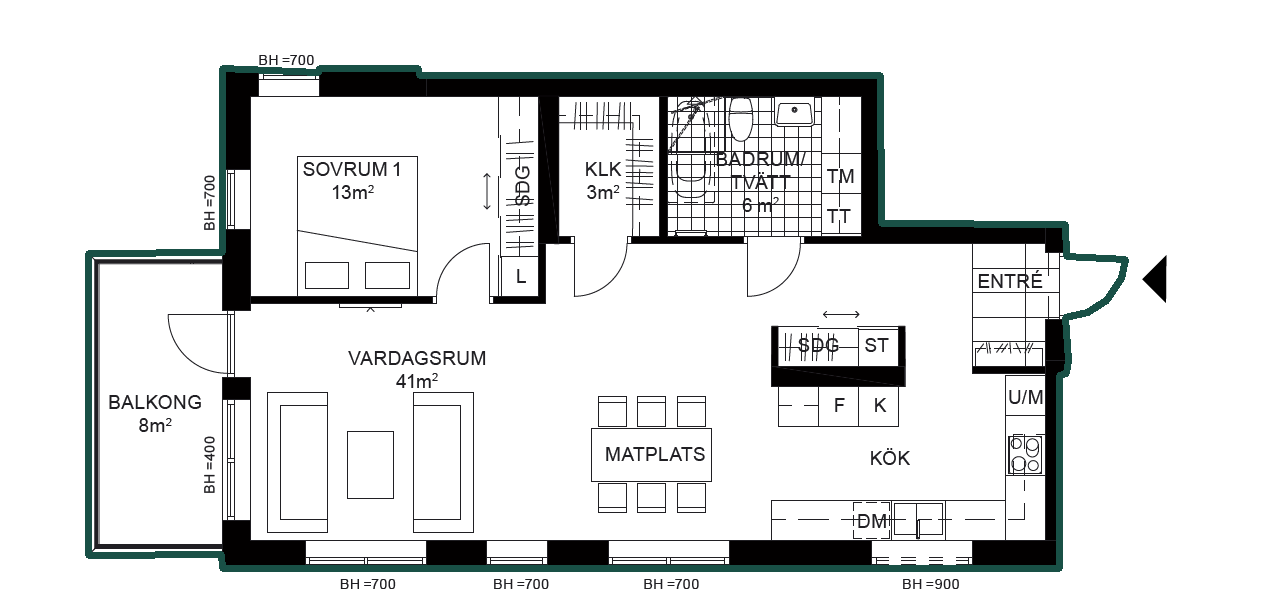

In [5]:

img_path = "C:\\Users\\lalah\\OneDrive\\Desktop\\floorPlan2.png"

# Read floorplan image
img = cv2.imread(img_path)

# Create blank image
height, width, channels = img.shape
blank_image = img.copy()

# Grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# detect outer Contours (simple floor or roof solution), paint them red on blank_image
contour, c_img = detect.outer_contours(gray, blank_image, color=(25,80,70))

# Display
display(Image.fromarray(blank_image))

# Auto Rescale Image
Okey, so we have now started scripting and already detected a fancy floor/roof of the floorplan.
Now we will look closer at a problem I had for a long time, where Images that were too big or too small couldn't really be used. To solve this, we want to scale the images up or down. To know how much an image should be scaled we calculate the average corner-distance of objects we suspect to be walls. Then scale image to match the prefered wall-size for optimal detections.

This functionality is now a setting in the `config.ini` file. By setting `rescale_image = True` it will be activated and try to automatically rescale too large or too small images. We use a default calibration image that can be replaced to achive other results.

After a rescale the floor/roof has to be recalculated with the new image. The outer contour detection will then serve as threshold of upcoming detections.

# Detect Walls

The next step is to detect walls of the floorplans. For this we use filters with noise reduction and corner detetion. For this to work properly the input images needs to have an appropriate size. Hence the rescaling in the earier step. 

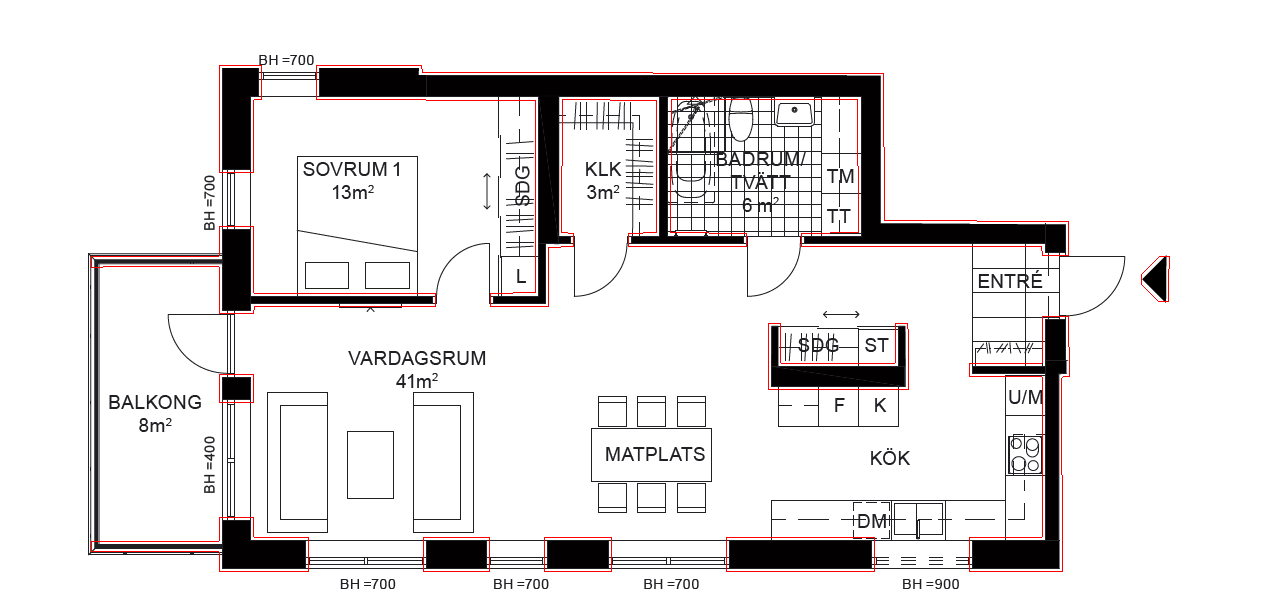

In [7]:
# Create new blank image
blank_image = img.copy()

# Perform filter on grayscaled input image
wall_img = detect.wall_filter(gray)

"""
Detect Wall
"""
boxes, w_img = detect.precise_boxes(wall_img, blank_image, color=[255,0,0])

# Display
display(Image.fromarray(blank_image))

# Remove walls outside of outer contour

Next up we perform a filter to remove all walls that is positioned outside of the outer contour.

# Detect Rooms

Next we detect rooms. The current room detection uses a combined line and corner detection to find where walls align and then separate into different rooms. This solution works fine, however it could be discussed if it doesn't make more sense to use a distance transform solution instead. It would be easier to understand and hopefully a little better result. So this might a part of the project that will be updated in the future.

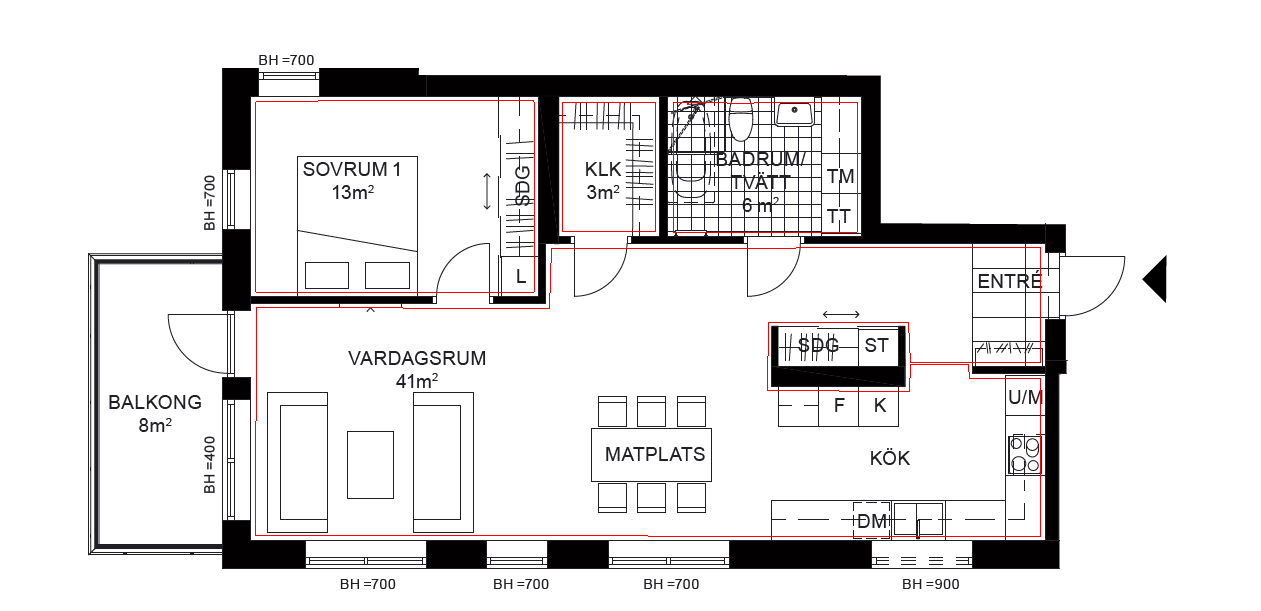

In [208]:
# Create new blank image
blank_image = img.copy()

gray = ~wall_img

# Find rooms
rooms, colored_rooms = detect.find_rooms(gray)

gray_rooms = cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

boxes, blank_image = detect.precise_boxes(
    gray_rooms, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

# Detect Windows & Doors

Now for the more advanced detections. The detection of windows and doors are divided into three steps. Firstly we detect detail boxes, which are boxes that are door or window sized relative to the input image and wall size. 

Next we use Orb feature extraction between door models and our floorplan. Then use linear projection to calculate angles and rescale doors to fit the floorplan properly. One solution to improve the door detection would be to add more door models in the `images/Models/Door/` folder. 

Now we know where all doors are and where all doors and windows are. So all we have to do is to compare the general position of the doors compared to the detailed boxes to know which are windows and which are doors. 

See all steps with illustrations below.

## Detect Details

The details detection is basicly the same as room detection but for smaller boxes. We are looking for smaller areas between walls using corner detection.

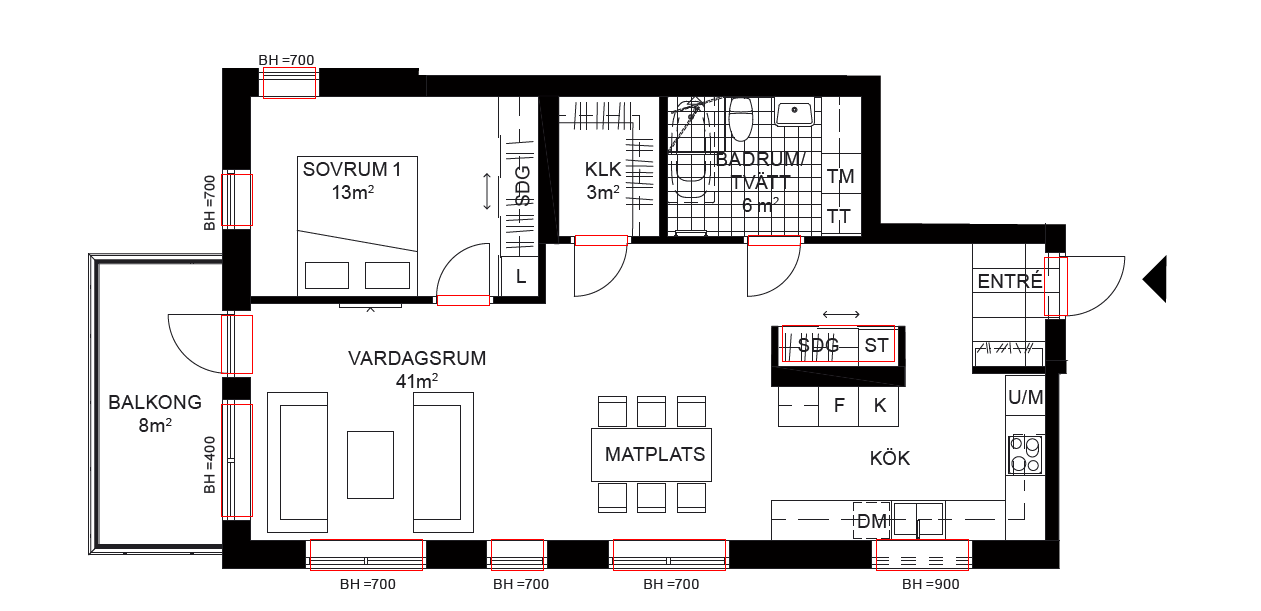

In [209]:
# Create new blank image
blank_image = img.copy()

doors, colored_doors = detect.find_details(gray.copy())
gray_details = cv2.cvtColor(colored_doors, cv2.COLOR_BGR2GRAY)
boxes, blank_image = detect.precise_boxes(
    gray_details, blank_image, color=(255, 0, 0)
)

# Display
display(Image.fromarray(blank_image))

## Detect Doors

The door detection uses ORB feature extraction. See below how features relate between the door model and the floorplan. Additional calculations are needed to also place the doors at correct position, rotation and scale. We use five points per door to get an OK accuracy.

The code for this example can be found in `Development Center/FloorplanLibDemo/find_windows_and_doors.py`.

![door_feature](../Images/Demos/door_feature_extraction.PNG)

## Detect windows

The final step of the detection is to distinguish windows from the details detections. We do that by comparing the positions of each door with the details detections. See result below.

The code for this example can be found in `Development Center/FloorplanLibDemo/find_windows_and_doors.py`.

![door_windows](../Images/Demos/windows_and_doors.PNG)

# Generate storage data files

Now that all detections are done the data must be saved, because generally the project executes in two instances. The first handles the input images with openCV and the other part is executed within the Blender program. In order to share data between the two, all necessary data is stored in .txt files under the `./Data/<id>` folder. Where ID is the generated incremented id of the current floorplan.

For each detection a horizontal and vertical file is saved for faces and verts. Verts describe the position of each object corner to be created. And faces describe the order of which the positions should be drawn. This is important in computer graphics!

There is also a transform file containing information about the stored floorplan data. An example can look like this:
`{"position": [0, 0, 0], "rotation": [0, 0, 0], "shape": [10.77, 5.06, 1]}`


# Generate Blender file

The next step is to generate the 3d model from the stored data. We do this by creating a `bpy` python script and executing it within the blender application. This requires blender to be installed on your device. All blender scripts are located in `Blender/` folder. All objects in the floorplan is stored in an appropriate structure to help with organization of the 3d model.

# Generate multi level floorplan / Stacking

There are two ways of generating multiple floorplans at once.
Eighter use simple stacking along an axis or use the cylindric stacking which will be centered and rotated around a point.
See the `Stacking` folders for examples of how to use them.


# Reformat blender project

Sometimes it is interesing to generate specific object formats directly instead of doing it by hand in blender. Therefore we have added a solution to say which format the model should be saved as. For instance `.obj` to be imported directly into Unity or Unreal Engine.

# Floorplan To Blender Server 

In an attempt to make the library more accessible a RMI server implementation was created where images can be sent to the server and models generated and downloaded. See more in `Server/` folder.

![swagger](../Images/Demos/swaggerdemo.gif)

# Docker

To make the implementation useable, save and reliable a dockerfile, docker-compose and connection to dockerhub exist. The image can run in three modes. Server, document and single script mode. The server mode is used for hosting the FTBL Server implementation. The document mode starts this notebook on localhost. The single script mode runs the script once in a secure environment. 

There are many advantages of using containers and I hope the docker image will be helpful.

# Usages in other projects

The models can be used in many ways. I have for instance used unity and AR foundation to implement a AR implementation to better interact with the floorplan models. See more below.

## Unity AR foundation

The code for this project is shared in a separate open source project.

<p align="left">
  <img width="460" height="300" src="../Images/Demos/ardemo.gif">
</p>

### AR foundation real life scaling of floorplans

<p align="left">
  <img width="460" height="300" src="../Images/Demos/arrealifedemo.gif">
</p>

### AR foundation interior design of floorplans

<p align="left">
  <img width="460" height="300" src="../Images/Demos/PlaceObjectInRoomDemo.gif">
</p>

### AR foundation with MediaPipe Hands interactions

<p align="left">
  <img width="460" height="300" src="../Images/Demos/InteractDemo.gif">
</p>


## Blender Plugin

It has been discussed to create a direct plugin for this project in blender, to be more accessible. This might be added in the future also.

# Thank You

Thanks for using the implementation.

Best regards,

@grebtsew